In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from monotonenorm import GroupSort, direct_norm, SigmaNet
# pip install -e . in the directory with setup.py if you do not have monotonenorm installed
torch.manual_seed(0)
plt.style.use('mpl-config')

We will make a simple toy regression model to fit the following 1D function $$f(x) = log(x) + \epsilon(x)$$
where $\epsilon$ is a gaussian noise term whose variance is linearly increasing in x. 
In this toy model we will assume that we have good reason to believe that the function we are trying to fit is monotonic (despite non-monotnic behavior of the noise). For example, we are building a trigger algorithm to discriminate between signal and background events. Rarer events are more likely to be signal and thus we should employ a network which is monotonic in some "rareness" feature. Another example could be a hiring classifier where (all else equal) higher school grades should imply better chances of being hired. 

Now we will fit an unconstrained model and monotonic Lipschitz model.

In [2]:
# Config
EPOCHS = 10000 
N = 30           # Number of points 
max_range = 50   # Maximum range of x
loss_func = torch.nn.L1Loss()

# simple toy data
x_train = torch.linspace(1, max_range, N).view(-1, 1)
y_train = torch.log(x_train)
# Adding linearly increasing noise
noise = torch.randn(N).view(-1, 1) * torch.linspace(0.01, 0.3, N).view(-1, 1)
y_train -= noise

# Plot training data
# plt.scatter(x_train.numpy(), y_train.numpy())
# plt.show()
class UnconstrainedModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 1),
)
    def forward(self, x):
        return self.model(x)

# Build a Lipschitz-1 network
class RobustModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            direct_norm(torch.nn.Linear(1, 16)),
            GroupSort(8),
            direct_norm(torch.nn.Linear(16, 16)),
            GroupSort(8),
            direct_norm(torch.nn.Linear(16, 16)),
            GroupSort(8),
            direct_norm(torch.nn.Linear(16, 16)),
            GroupSort(8),
            direct_norm(torch.nn.Linear(16, 16)),
            GroupSort(8),
            direct_norm(torch.nn.Linear(16, 1)),
        )

    def forward(self, x):
        return self.model(x)

model = UnconstrainedModel()
monotonic_model = SigmaNet(RobustModel(), sigma=1.)

optim = torch.optim.Adam(model.parameters(), lr=5e-3)
optim_robust = torch.optim.Adam(monotonic_model.parameters(), lr=1e-3)

# Train both models at the same time
pbar = tqdm(range(EPOCHS))
for i in pbar:
    y = model(x_train)
    y_robust = monotonic_model(x_train)
    loss = loss_func(y, y_train)
    loss_robust = loss_func(y_robust, y_train)
    loss_robust.backward()
    loss.backward()
    optim.step()
    optim_robust.step()
    optim.zero_grad()
    optim_robust.zero_grad()
    pbar.set_description(
        f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")


  0%|          | 0/10000 [00:00<?, ?it/s]

Saved monotonic_dependance.png


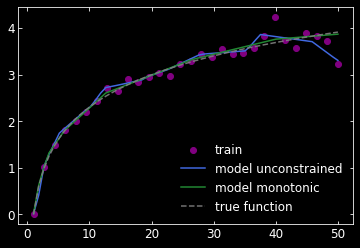

In [3]:
# Plot results
x_linspace = torch.linspace(1, max_range, 2 * N).view(-1, 1)
y_linspace = torch.log(x_linspace)
with torch.no_grad():
    y = model(x_linspace)
    y_robust = monotonic_model(x_linspace)

plt.scatter(x_train.numpy(), y_train.numpy(), c='purple', label='train')
plt.plot(x_linspace.numpy(), y.numpy(), label="model unconstrained")
plt.plot(x_linspace.numpy(), y_robust.numpy(), label="model monotonic")
plt.plot(x_linspace, y_linspace, c='gray',
         linestyle='--', alpha=0.9, label="true function")
plt.legend()
figname = "monotonic_dependance.png"
plt.savefig(figname)
print("Saved", figname)
plt.show()

Now we will make a different toy model with one noisy data point. This will show that the Lipschitz continuous network is more robust against outliers than an unconstrained network because its gradient with respect to the input is bounded between -1 and 1. Additionally, it is more robust against adversarial attacks/data corruption for the same reason.

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved robust_against_noisy_outlier.png


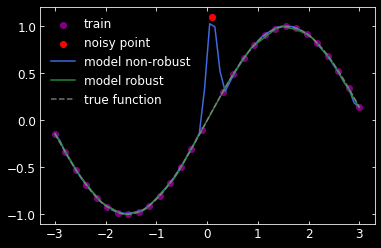

In [4]:
# Now we will make a simple function
x_train = torch.linspace(-3, 3, N).view(-1, 1)
y_train = torch.sin(x_train)
y_train[N // 2] += 1

model = UnconstrainedModel()
robust_model = RobustModel()

optim = torch.optim.Adam(model.parameters(), lr=5e-3)
optim_robust = torch.optim.Adam(robust_model.parameters(), lr=1e-3)

pbar = tqdm(range(EPOCHS))
for i in pbar:
    y = model(x_train)
    y_robust = robust_model(x_train)
    loss = loss_func(y, y_train)
    loss_robust = loss_func(y_robust, y_train)
    loss_robust.backward()
    loss.backward()
    optim.step()
    optim_robust.step()
    optim.zero_grad()
    optim_robust.zero_grad()
    pbar.set_description(
        f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")


x_linspace = torch.linspace(-3, 3, 2 * N).view(-1, 1)
y_linspace = torch.sin(x_linspace)
with torch.no_grad():
    y = model(x_linspace)
    y_robust = robust_model(x_linspace)

plt.scatter(x_train.numpy(), y_train.numpy(), c='purple', label='train')
plt.scatter(x_train.numpy()[N // 2], y_train.numpy()[N // 2], c="r", label='noisy point')
plt.plot(x_linspace.numpy(), y.numpy(), label="model non-robust")
plt.plot(x_linspace.numpy(), y_robust.numpy(), label="model robust")
plt.plot(x_linspace, y_linspace, c='gray',
         linestyle='--', alpha=0.9, label="true function")
plt.legend()
figname = "robust_against_noisy_outlier.png"
plt.savefig(figname)
print("Saved", figname)
plt.show()